In [46]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [19]:
# Check DB file is accessible and connect to db

db_path = "../database/thermostat_analysis.db"

if os.path.exists(db_path):
    conn = sqlite3.connect(db_path)
    print("Connected to DB successfully.")
else:
    print("DB file not found. Please check the path.")

Connected to DB successfully.


In [20]:
# To ensure if the connection is successful

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('weather_data',), ('weather_data_final',), ('thermostat_data_final',), ('thermostat_data_hourly',)]


 ### Resampling & Merging with Weather Data**

The original thermostat dataset was logged at **5-minute intervals**. To align it with the hourly weather data,  performed a **custom resampling to 1-hour intervals**, aggregating relevant fields:

- Temperature and humidity fields: **mean**
- Fan runtime (`fan_sec`): **sum**
- Categorical fields (e.g., `system_mode`, `program_mode`): **mode**

After resampling, saved the data as `thermostat_df_hourly_custom.csv`.

Then performed an **inner SQL join** with the cleaned weather dataset (`weather_data_final`) using the common `timestamp` field.

Result:
- A clean, merged hourly dataset with both indoor HVAC performance and outdoor weather conditions parameters.
- Ready for time series analysis and visualization.

In [21]:
# Define SQL JOIN query

query = """
SELECT 
    t.timestamp,
    t.system_mode,
    t.program_mode,
    t.cool_set_temp_f,
    t.heat_set_temp_f,
    t.current_temp_f,
    t.current_humidity_rh,            
    t.fan_sec,
    t.fan_runtime_category,
    w.outdoor_temp_f,
    w.outdoor_humidity
FROM 
    thermostat_data_hourly t
JOIN 
    weather_data_final w
ON 
    t.timestamp = w.timestamp
ORDER BY 
    t.timestamp;
"""

In [22]:
# Execute the query

merged_df = pd.read_sql_query(query, conn)

In [23]:
# Close the connection

conn.close()

In [24]:
# Preview the merged data

merged_df.head(5)

,timestamp,system_mode,program_mode,cool_set_temp_f,heat_set_temp_f,current_temp_f,current_humidity_rh,fan_sec,fan_runtime_category,outdoor_temp_f,outdoor_humidity
0,2024-05-01 00:00:00,compressorcooloff,sleep,74.5,69.5,72.88,57.0,3300.0,High,58.46,75
1,2024-05-01 01:00:00,compressorcooloff,sleep,74.5,69.5,72.43,57.0,3300.0,High,56.30,80
2,2024-05-01 02:00:00,compressorcooloff,sleep,74.5,69.5,72.05,57.0,3300.0,High,55.04,83
3,2024-05-01 03:00:00,compressorcooloff,sleep,74.5,69.5,71.59,57.0,3300.0,High,54.14,86
4,2024-05-01 04:00:00,compressorcooloff,sleep,74.5,69.5,71.17,57.0,3300.0,High,54.14,88


In [25]:
# Save the merged df to a CSV file

merged_df.to_csv("../data/processed/merged_thermostat_weather_data.csv", index=False)

print("Merged data saved to: ../data/processed/merged_thermostat_weather_data.csv")

Merged data saved to: ../data/processed/merged_thermostat_weather_data.csv


In [26]:
# Ensure timestamp is already datetime

merged_df['timestamp'].dtype

dtype('O')

In [27]:
# since the dtype is String, converting it into datetime format suitable for line plots and time-based filters

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

In [28]:
merged_df.set_index('timestamp', inplace=True)

### Timestamp Consistency Check (1-Hour Interval)

To ensure the `merged_df` dataset is properly structured for time series analysis, I checked the time difference between consecutive timestamps using the following code:

```python
merged_df.index.to_series().diff().value_counts().head(10)
O/P:
0 days 01:00:00    10223 
```

### Interpretation:
- All timestamps are spaced exactly 1 hour apart, confirming a regular hourly interval.
- This ensures the time series is clean, evenly spaced, and ready for analysis such as daily/weekly trends, system behavior over time, and correlation with weather data.

In [29]:
#Confirm that all intervals are 1 hour
merged_df.index.to_series().diff().value_counts().head(10)

timestamp
0 days 01:00:00    10223
Name: count, dtype: int64

### Timestamp Component Extraction
- Extracted key components from the `timestamp` column in the merged dataset, to enable time_based grouping and anlysis
- Makes it easier to analyzze trends like daily usage, hourly patterns, or weekday/weekend behaviors.

In [31]:
print(merged_df.index.name)

timestamp


In [33]:
merged_df.index.dtype

dtype('<M8[ns]')

In [34]:
# Extract timestamp components

merged_df['date'] = merged_df.index.date
merged_df['hour'] = merged_df.index.hour
merged_df['month'] = merged_df.index.month
merged_df['weekday'] = merged_df.index.day_name()

In [36]:
merged_df.columns


Index(['system_mode', 'program_mode', 'cool_set_temp_f', 'heat_set_temp_f',
       'current_temp_f', 'current_humidity_rh', 'fan_sec',
       'fan_runtime_category', 'outdoor_temp_f', 'outdoor_humidity', 'date',
       'hour', 'month', 'weekday'],
      dtype='object')

# Visualization

## 1. HVAC Runtime Over Time

### Objective

To understand how long the HVAC fan operates across different time periods (daily, hourly, and by duration category). This helps reveal usage patterns, inefficiencies, or potential overuse.

### Outcomes
- Identifying daily peaks or anomalies in HVAC usage
- Detecting high-load hours where HVAC runs the most
- Understanding how often the fan runs for short, medium, or long durations
This lays the foundation for energy optimization by aligning usage with comfort needs and potential savings.

### 1A.  Daily Total Fan Runtime (Line Chart)

- Purpose: Visualize how much time the HVAC fan runs each day.
- Insight: Detect abnormal usage days that may indicate inefficient system settings or unusual behavior.

**Chart Insight**:  
- This line chart displays the **daily total HVAC fan runtime** (in hours) over the course of a year.  
- The consistent runtime between 23–24 hours during some periods reflects **manual fan settings** (55 min/hour).  
- The visible dips and occasional spikes are useful for identifying anomalies, power interruptions, or HVAC behavior changes due to external temperature or system modes.

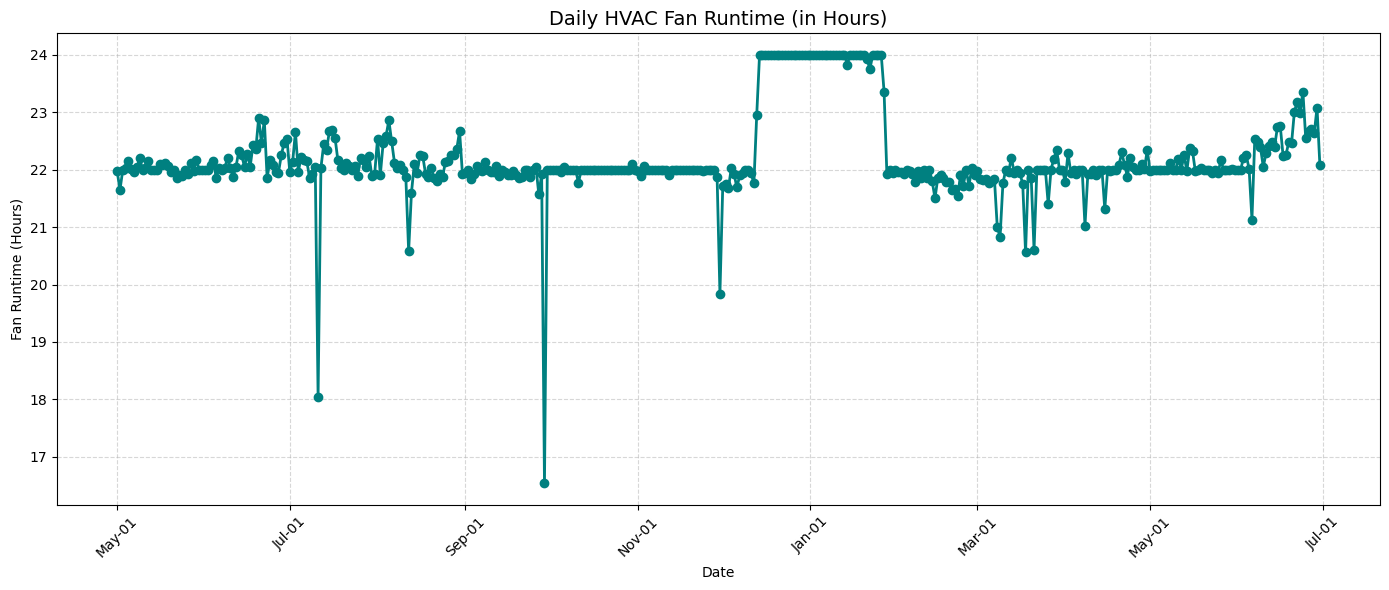

In [54]:
### 1A.  Daily Total Fan Runtime (Line Chart)

# Grouping data by date and summing total fan runtime in seconds per day
daily_runtime = merged_df.groupby('date')['fan_sec'].sum().reset_index()

# Converting fan runtime from seconds to hours and rounding to 2 decimal places
daily_runtime['fan_runtime_hours'] = (daily_runtime['fan_sec'] / 3600).round(2)

# Setting the chart size
plt.figure(figsize=(14, 6))

# Plotting the line chart with markers and custom color
plt.plot(daily_runtime['date'],                # x-axis: Date
         daily_runtime['fan_runtime_hours'],   # y-axis: Total runtime in hours
         marker='o', linestyle='-', color='teal', linewidth=2)

# Adding chart title and axis labels
plt.title('Daily HVAC Fan Runtime (in Hours)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Fan Runtime (Hours)')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Formatting x-axis date labels (e.g., Apr-01, May-02)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

# Adding grid lines with dashed style and transparency
plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting layout to prevent clipping
plt.tight_layout()

# Displaying the final plot
plt.show()

### 1B. Fan Runtime by Hour of Day (Bar Chart)

- Purpose: Understand which time of the day the HVAC is used most.
- Insight: Identify peak load hours for better scheduling or thermostat programming.

**ChartInsights**:
- This chart displays the total fan runtime (in hours) for each hour of the day (0–23), aggregated across 14 months of data.
- Given that the thermostat is configured to run the fan 55 minutes every hour, the bars hover around 390 hours (55 mins × ~570 days / 60), which is expected.
- The nearly uniform height across all 24 hours reflects consistent hourly usage, confirming the accuracy of both the dataset and the thermostat configuration.

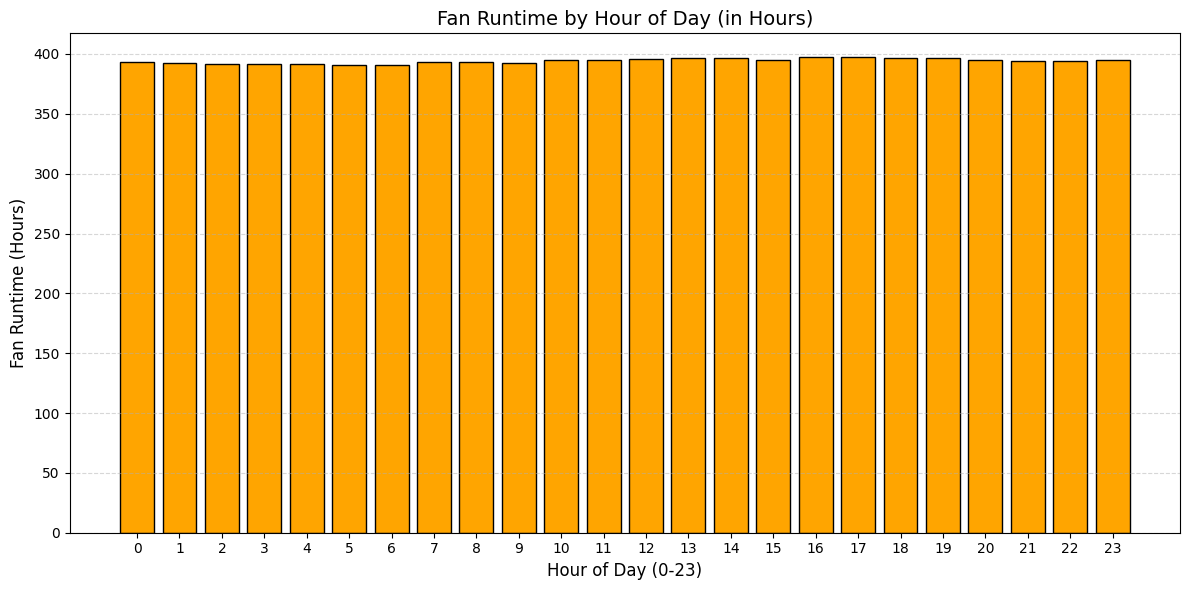

In [55]:
# 1B. Fan Runtime by Hour of Day (Bar Chart)

# Group the data by hour of the day and sum the fan runtime in seconds
hourly_runtime = merged_df.groupby('hour')['fan_sec'].sum().reset_index()

# Convert fan runtime from seconds to hours and round to 2 decimal places
hourly_runtime['fan_runtime_hours'] = (hourly_runtime['fan_sec'] / 3600).round(2)

# Create a bar chart to visualize fan usage by hour
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot a bar chart with hour on X-axis and runtime in hours on Y-axis
plt.bar(hourly_runtime['hour'], hourly_runtime['fan_runtime_hours'],
        color='orange', edgecolor='black')  # Set color and edge style

# Set the title and axis labels
plt.title('Fan Runtime by Hour of Day (in Hours)', fontsize=14)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Fan Runtime (Hours)', fontsize=12)
plt.xticks(range(0, 24))  # Show each hour clearly

# Show a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Make layout tight so labels and titles fit well
plt.tight_layout()

# Display the plot
plt.show()